In [88]:
from pathlib import Path
from mapillary_sls.datasets.msls import MSLS
from mapillary_sls.datasets.generic_dataset import ImagesFromList
from mapillary_sls.utils.utils import configure_transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mapillary_sls.utils.visualize import denormalize, visualize_triplets
from mapillary_sls.utils.eval import download_msls_sample

# Download MSLS sample

In [89]:
SAMPLE_CITIES_TEST = "miami"
SAMPLE_CITIES_TRAIN = "helsinki"

root_dir = Path('/data-lyh/MSLS_Data/').absolute()

if not root_dir.exists():
    download_msls_sample(root_dir)


# Load dataset for testing


In [107]:
# get transform
meta = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
transform = configure_transform(image_dim = (480, 640), meta = meta)

# positive are defined within a radius of 25 m
posDistThr = 5 #25

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'seq2seq'

# choose sequence length
seq_length = 3

# choose subtask to test on [all, s2w, w2s, o2n, n2o, d2n, n2d]
subtask = 'all'

val_dataset = MSLS(root_dir, cities = SAMPLE_CITIES_TEST, transform = transform, mode = 'test',
                   task = task, seq_length = seq_length, subtask = subtask, posDistThr = posDistThr)

opt = {'batch_size': 2}

# get images
qLoader = DataLoader(ImagesFromList(val_dataset.qImages[val_dataset.qIdx], transform), **opt)
dbLoader = DataLoader(ImagesFromList(val_dataset.dbImages, transform), **opt)

# get positive index (we allow some more slack: default 25 m)
pIdx = val_dataset.pIdx

=====> miami


In [108]:
num_batches = len(qLoader)
# Calculate the total number of data samples
total_samples = num_batches * qLoader.batch_size
print("Number of batches:", num_batches)
print("Total number of data samples:", total_samples)
# batch is a brunch of datase in a mini-batch size (qLoader.batch_size), the number of batch is num_batches
for batch in qLoader:
    x, y = batch
    #print(type(x))
    #print(y)
    # plt.figure(figsize=(30,20))
    # for i,im in enumerate(x):
    #     plt.subplot(1,seq_length, i+1)
    #     plt.imshow(denormalize(im[0].permute(1,2,0)))
    # plt.show()

Number of batches: 57
Total number of data samples: 114


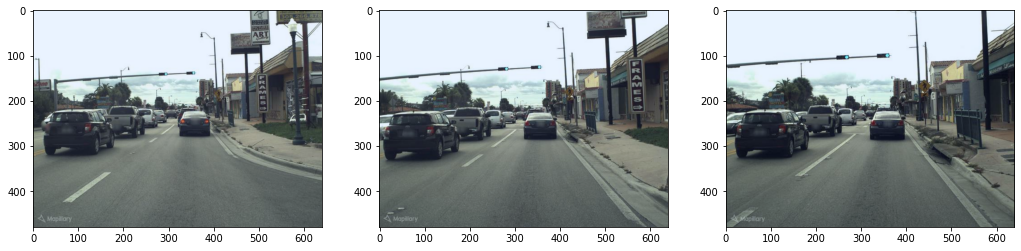

In [92]:
for batch in dbLoader:
    x, y = batch

    plt.figure(figsize=(30,20))
    for i,im in enumerate(x):
        plt.subplot(1,seq_length, i+1)
        plt.imshow(denormalize(im[0].permute(1,2,0)))
    plt.show() 
    break

# Load dataset for training (triplets)

In [91]:
posDistThr = 5

# negatives are defined outside a radius of 25 m
negDistThr = 25

# number of negatives per triplet
nNeg = 5

# number of cached queries
cached_queries = 1

# number of cached negatives, why there are so many negatives cached?
cached_negatives = 100

# whether to use positive sampling
positive_sampling = True

# choose the cities to load
cities = SAMPLE_CITIES_TRAIN

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'seq2seq'

# choose sequence length, why the seq_length should be odd number under seq2seq mode?
seq_length = 5

train_dataset = MSLS(root_dir, cities = cities, transform = transform, mode = 'train', task = task, seq_length = seq_length,
                    negDistThr = negDistThr, posDistThr = posDistThr, nNeg = nNeg, cached_queries = cached_queries,
                    cached_negatives = cached_negatives, positive_sampling = positive_sampling)

=====> helsinki
#Sideways [1447/8303]; #Night; [0/8303]
Forward and Day weighted with 1.0000
Sideways and Day weighted with 6.7381


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# divides dataset into smaller cache sets
train_dataset.new_epoch()

# creates triplets on the smaller cache set
train_dataset.update_subcache()

# create data loader
opt = {'batch_size': 1, 'shuffle': False}
trainDataloader = DataLoader(train_dataset, **opt)

# visualize a triplet
for batch in trainDataloader:
    visualize_triplets(batch, task)